In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

In [3]:
from collate_full_catalog import collate_catalog
a_string = 'a_0.911185'
idx_tobs = np.where(scale_factor_array >= float(a_string[2:]))[0][0]
t_today = cosmic_age_array[idx_tobs]

history_colnames = ('halo_id', 'halo_upid', 'halo_mpeak', 'sfr_mp', 'sm_mp', 'stellar_mass', 'sfr', 'a_first_infall')

histories = collate_catalog(a_string, history_colnames=history_colnames)
print("Number of galaxies = {0}".format(len(histories)))

... Assembling history data
Number of galaxies = 676555


In [4]:
from quenching_time import quenching_time
histories['quenching_time'] = quenching_time(histories['sfr_mp'], histories['sm_mp'])

In [5]:
histories['time_first_acc'] = np.interp(histories['a_first_infall'], scale_factor_array, cosmic_age_array)
histories['host_mpeak'] = histories['halo_mpeak']

In [6]:
from history_functions import ssfr_at_infall

histories['ssfr_at_infall'] = ssfr_at_infall(histories['sfr_mp'].data, 
                                histories['sm_mp'].data, histories['time_first_acc'].data)

satmask = (histories['gal_type'] == 'satellite') | (histories['gal_type'] == 'orphan')
sats = histories[satmask]
cenmask = histories['gal_type'] == 'central'
cens = histories[cenmask]

In [7]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(sats['halo_upid'], histories['halo_id'])
sats['host_mpeak'][idxA] = histories['halo_mpeak'][idxB]
histories['host_mpeak'][satmask] = sats['host_mpeak']

In [8]:
quenched_satmask = np.log10(sats['sfr']/sats['stellar_mass']) < -11
quenched_sats = sats[quenched_satmask]

# Plot fraction that quenched after infall

In [9]:
logsm_low, logsm_high, num_sm_bins = 9, 11.35, 20
sm_bins = np.logspace(logsm_low, logsm_high, num_sm_bins)
sm_mids = 10**((np.log10(sm_bins)[1:] + np.log10(sm_bins)[:-1])/2.)

host_mass_bins = [10**12, 10**13, 10**14, np.inf]

frac_quenched_as_sat = np.zeros(len(sm_bins)-1)
frac_quenched_as_sat_milky_way = np.zeros(len(sm_bins)-1)
frac_quenched_as_sat_group = np.zeros(len(sm_bins)-1)
frac_quenched_as_sat_cluster = np.zeros(len(sm_bins)-1)

for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (quenched_sats['stellar_mass'] > sm_low) & (quenched_sats['stellar_mass'] < sm_high)
    sm_bin_active_at_infall_mask = sm_bin_mask * (quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat[i] = len(quenched_sats[sm_bin_active_at_infall_mask])/float(len(quenched_sats[sm_bin_mask]))
    
    milky_way_sm_bin_mask = sm_bin_mask*(quenched_sats['host_mpeak'] > host_mass_bins[0])*(quenched_sats['host_mpeak'] < host_mass_bins[1])
    milky_way_sm_bin_active_at_infall_mask = milky_way_sm_bin_mask*(quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat_milky_way[i] = len(quenched_sats[milky_way_sm_bin_active_at_infall_mask])/float(len(quenched_sats[milky_way_sm_bin_mask]))

    group_sm_bin_mask = sm_bin_mask*(quenched_sats['host_mpeak'] > host_mass_bins[1])*(quenched_sats['host_mpeak'] < host_mass_bins[2])
    group_sm_bin_active_at_infall_mask = group_sm_bin_mask*(quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat_group[i] = len(quenched_sats[group_sm_bin_active_at_infall_mask])/float(len(quenched_sats[group_sm_bin_mask]))

    cluster_sm_bin_mask = sm_bin_mask*(quenched_sats['host_mpeak'] > host_mass_bins[2])*(quenched_sats['host_mpeak'] < host_mass_bins[3])
    cluster_sm_bin_active_at_infall_mask = cluster_sm_bin_mask*(quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat_cluster[i] = len(quenched_sats[cluster_sm_bin_active_at_infall_mask])/float(len(quenched_sats[cluster_sm_bin_mask]))


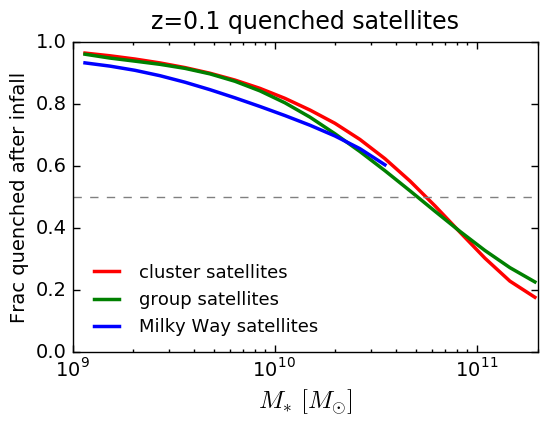

In [10]:
from scipy.signal import savgol_filter, medfilt

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=18)
ylabel = ax.set_ylabel('Frac quenched after infall', fontsize=14)
title = ax.set_title('z=0.1 quenched satellites', fontsize=17, y=1.02) # y param fixes an overhanging title

ax.plot(sm_mids, savgol_filter(frac_quenched_as_sat_cluster, 17, 5), color='red', 
        linewidth=2.5, label = "cluster satellites")

ax.plot(sm_mids, savgol_filter(frac_quenched_as_sat_group, 17, 4), color='green', 
        linewidth=2.5, label = "group satellites")

# ax.plot(sm_mids, savgol_filter(frac_quenched_as_sat, 13, 4), color='k', 
#         linewidth=2.5, label = "all satellites")

ax.plot(sm_mids[:-6], savgol_filter(frac_quenched_as_sat_milky_way[:-6], 13, 5), color='blue', 
        linewidth=2.5, label = "Milky Way satellites")

ax.plot(np.logspace(9, 12, 100), np.zeros(100) + 0.5, '--', color='gray')

plt.tick_params(axis='x', length=5, width=1, which='major') 
plt.tick_params(axis='x', length=2, width=1, which='minor') 
plt.tick_params(axis='y', length=5, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin = 10**9, xmax=2*10**11)
plt.ylim(ymin = 0, ymax = 1)
plt.legend(frameon=False, loc='lower left', fontsize=13)

fig.savefig('FIGS/post_infall_quenching_fractions_z0p1.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

# Plot the quenching time

In [11]:
from quenching_time import quenching_time
quenched_sats['quenching_time'] = quenching_time(quenched_sats['sfr_mp'], quenched_sats['sm_mp'])

In [12]:
quenched_sats['quenching_time_delay'] = quenched_sats['quenching_time'] - quenched_sats['time_first_acc'] 

In [13]:
log_mhost_bins = np.array((12, 13, 14, np.inf))
mhost_bins = 10**log_mhost_bins

In [14]:
quenching_time_delay = np.zeros((len(sm_bins)-1, 4))
for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (quenched_sats['stellar_mass'] > sm_low) & (quenched_sats['stellar_mass'] < sm_high)
    quenching_time_delay[i, 0] = np.mean(quenched_sats[sm_bin_mask]['quenching_time_delay'])
    
    mhost_mask = sm_bin_mask * (quenched_sats['host_mpeak'] >= mhost_bins[0])
    mhost_mask *= (quenched_sats['host_mpeak'] < mhost_bins[1])
    if len(quenched_sats[mhost_mask]) > 0:
        quenching_time_delay[i, 1] = np.mean(quenched_sats[mhost_mask]['quenching_time_delay'])

    mhost_mask = sm_bin_mask * (quenched_sats['host_mpeak'] >= mhost_bins[1])
    mhost_mask *= (quenched_sats['host_mpeak'] < mhost_bins[2])
    if len(quenched_sats[mhost_mask]) > 0:
        quenching_time_delay[i, 2] = np.mean(quenched_sats[mhost_mask]['quenching_time_delay'])

    mhost_mask = sm_bin_mask * (quenched_sats['host_mpeak'] >= mhost_bins[2])
    mhost_mask *= (quenched_sats['host_mpeak'] < mhost_bins[3])
    if len(quenched_sats[mhost_mask]) > 0:
        quenching_time_delay[i, 3] = np.mean(quenched_sats[mhost_mask]['quenching_time_delay'])


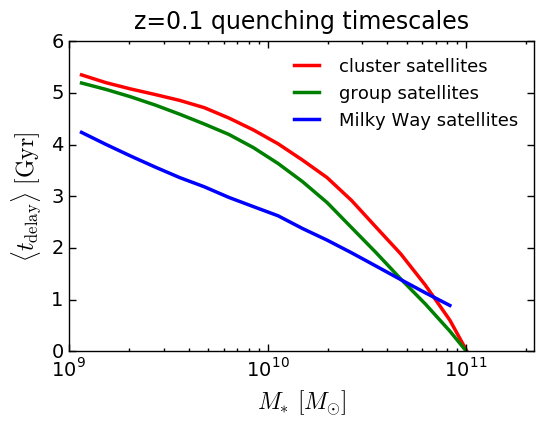

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=17)
ylabel = ax.set_ylabel(r'$\langle t_{\rm delay} \rangle$ $[{\rm Gyr}]$', fontsize=17)
title = ax.set_title('z=0.1 quenching timescales', fontsize=17, y=1.02) # y param fixes an overhanging title

ax.plot(sm_mids, savgol_filter(quenching_time_delay[:, 3], 9, 3), color='red', 
        linewidth=2.5, label = "cluster satellites")
ax.plot(sm_mids, savgol_filter(quenching_time_delay[:, 2], 9, 3), color='green', 
        linewidth=2.5, label = "group satellites")
ax.plot(sm_mids[:-3], savgol_filter(quenching_time_delay[:, 1][:-3], 9, 3), color='blue', 
        linewidth=2.5, label = "Milky Way satellites")


plt.tick_params(axis='x', length=5, width=1, which='major') 
plt.tick_params(axis='x', length=2, width=1, which='minor') 
plt.tick_params(axis='y', length=5, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin = 10**9, xmax=2.2*10**11)
plt.ylim(ymin = 0, ymax = 6.)
plt.legend(frameon=False, loc='upper right', fontsize=13)

fig.savefig('FIGS/quenching_timescales_z0p1.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

# Fraction quenched because of infall

In [16]:
logsm_low, logsm_high, num_sm_bins = 9., 11.35, 20
sm_bins = np.logspace(logsm_low, logsm_high, num_sm_bins)
sm_mids = 10**((np.log10(sm_bins)[1:] + np.log10(sm_bins)[:-1])/2.)

host_mass_bins = [10**12, 10**13, 10**14, np.inf]

frac_quenched_cen = np.zeros(len(sm_bins)-1)
frac_quenched_sat = np.zeros(len(sm_bins)-1)
frac_quenched_sat_milky_way = np.zeros(len(sm_bins)-1)
frac_quenched_sat_group = np.zeros(len(sm_bins)-1)
frac_quenched_sat_cluster = np.zeros(len(sm_bins)-1)

for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (cens['stellar_mass'] > sm_low) & (cens['stellar_mass'] < sm_high)
    sm_bin_active_at_infall_mask = sm_bin_mask * (np.log10(cens['sfr']/cens['stellar_mass']) < -11)
    frac_quenched_cen[i] = len(cens[sm_bin_active_at_infall_mask])/float(len(cens[sm_bin_mask]))

    sm_bin_mask = (sats['stellar_mass'] > sm_low) & (sats['stellar_mass'] < sm_high)
    sm_bin_active_at_infall_mask = sm_bin_mask * (np.log10(sats['sfr']/sats['stellar_mass']) < -11)
    frac_quenched_sat[i] = len(sats[sm_bin_active_at_infall_mask])/float(len(sats[sm_bin_mask]))

    milky_way_sm_bin_mask = sm_bin_mask*(sats['host_mpeak'] > host_mass_bins[0])*(sats['host_mpeak'] < host_mass_bins[1])
    milky_way_sm_bin_active_at_infall_mask = milky_way_sm_bin_mask*(np.log10(sats['sfr']/sats['stellar_mass']) < -11)
    frac_quenched_sat_milky_way[i] = len(sats[milky_way_sm_bin_active_at_infall_mask])/float(len(sats[milky_way_sm_bin_mask]))

    group_sm_bin_mask = sm_bin_mask*(sats['host_mpeak'] > host_mass_bins[1])*(sats['host_mpeak'] < host_mass_bins[2])
    group_sm_bin_active_at_infall_mask = group_sm_bin_mask*(np.log10(sats['sfr']/sats['stellar_mass']) < -11)
    frac_quenched_sat_group[i] = len(sats[group_sm_bin_active_at_infall_mask])/float(len(sats[group_sm_bin_mask]))

    cluster_sm_bin_mask = sm_bin_mask*(sats['host_mpeak'] > host_mass_bins[2])*(sats['host_mpeak'] < host_mass_bins[3])
    cluster_sm_bin_active_at_infall_mask = cluster_sm_bin_mask*(np.log10(sats['sfr']/sats['stellar_mass']) < -11)
    frac_quenched_sat_cluster[i] = len(sats[cluster_sm_bin_active_at_infall_mask])/float(len(sats[cluster_sm_bin_mask]))


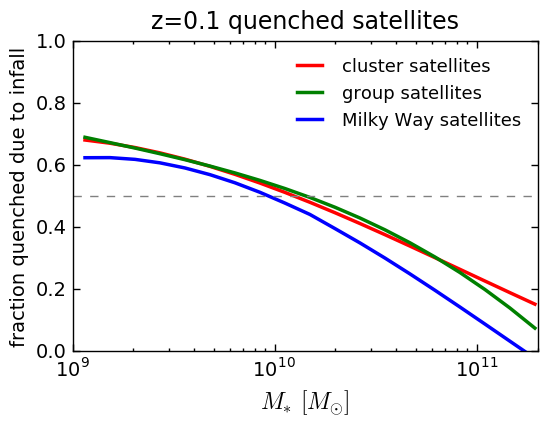

In [19]:
from scipy.signal import medfilt

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=17)
ylabel = ax.set_ylabel('fraction quenched due to infall', fontsize=14)
title = ax.set_title('z=0.1 quenched satellites', fontsize=17, y=1.02) # y param fixes an overhanging title

infall_caused_quenched_fraction_z0_cluster_x = sm_mids
infall_caused_quenched_fraction_z0_cluster_y = (frac_quenched_sat_cluster - frac_quenched_cen)/frac_quenched_sat_cluster
infall_caused_quenched_fraction_z0_cluster_y = savgol_filter(infall_caused_quenched_fraction_z0_cluster_y, 19, 3)

infall_caused_quenched_fraction_z0_group_x = sm_mids
infall_caused_quenched_fraction_z0_group_y = (frac_quenched_sat_group - frac_quenched_cen)/frac_quenched_sat_group
infall_caused_quenched_fraction_z0_group_y = savgol_filter(infall_caused_quenched_fraction_z0_group_y, 19, 3)

infall_caused_quenched_fraction_z0_milky_way_x = sm_mids
infall_caused_quenched_fraction_z0_milky_way_y = (frac_quenched_sat_milky_way - frac_quenched_cen)/frac_quenched_sat_milky_way
infall_caused_quenched_fraction_z0_milky_way_y = medfilt(infall_caused_quenched_fraction_z0_milky_way_y, 5)
infall_caused_quenched_fraction_z0_milky_way_y = savgol_filter(infall_caused_quenched_fraction_z0_milky_way_y, 17, 3)


ax.plot(infall_caused_quenched_fraction_z0_cluster_x, infall_caused_quenched_fraction_z0_cluster_y, color='red', 
        linewidth=2.5, label = "cluster satellites")
ax.plot(infall_caused_quenched_fraction_z0_group_x, infall_caused_quenched_fraction_z0_group_y, color='green', 
        linewidth=2.5, label = "group satellites")
ax.plot(infall_caused_quenched_fraction_z0_milky_way_x, infall_caused_quenched_fraction_z0_milky_way_y, color='blue', 
        linewidth=2.5, label = "Milky Way satellites")
ax.plot(np.logspace(9, 12, 100), np.zeros(100)+0.5, '--', color='gray')
plt.tick_params(axis='x', length=5, width=1, which='major') 
plt.tick_params(axis='x', length=2, width=1, which='minor') 
plt.tick_params(axis='y', length=5, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin = 10**9, xmax=2*10**11)
plt.ylim(ymin = 0, ymax = 1)
plt.legend(frameon=False, loc='upper right', fontsize=13)

fig.savefig('FIGS/infall_caused_quenched_fraction_z0p1.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

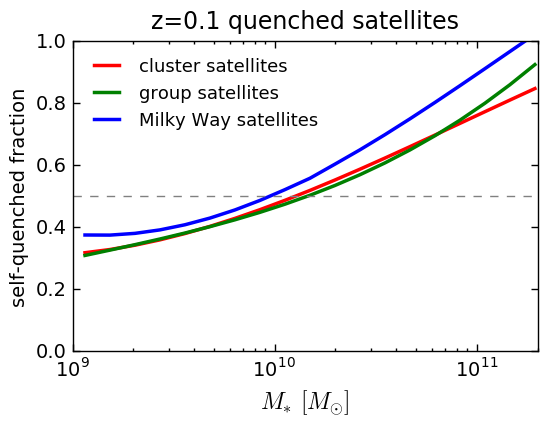

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=17)
ylabel = ax.set_ylabel('self-quenched fraction', fontsize=14)
title = ax.set_title('z=0.1 quenched satellites', fontsize=17, y=1.02) # y param fixes an overhanging title

ax.plot(sm_mids, 1-infall_caused_quenched_fraction_z0_cluster_y, color='red', 
        linewidth=2.5, label = "cluster satellites")
ax.plot(sm_mids, 1-infall_caused_quenched_fraction_z0_group_y, color='green', 
        linewidth=2.5, label = "group satellites")
ax.plot(sm_mids, 1-infall_caused_quenched_fraction_z0_milky_way_y, color='blue', 
        linewidth=2.5, label = "Milky Way satellites")
ax.plot(np.logspace(9, 12, 100), np.zeros(100)+0.5, '--', color='gray')

plt.tick_params(axis='x', length=5, width=1, which='major') 
plt.tick_params(axis='x', length=2, width=1, which='minor') 
plt.tick_params(axis='y', length=5, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin = 10**9, xmax=2*10**11)
plt.ylim(ymin = 0, ymax = 1)
plt.legend(frameon=False, loc='upper left', fontsize=13)

fig.savefig('FIGS/self_quenched_fraction_z0.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

# Compare infall time distributions 

### Compare infall time distributions: Mhost-dependence

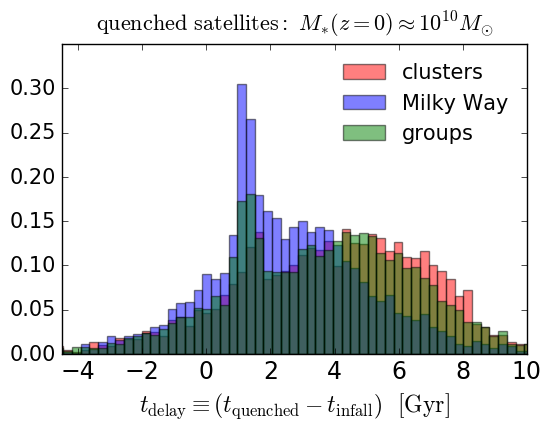

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm_low, sm_high = 10, 10.25

sm_mask = (quenched_sats['stellar_mass'] > 10**sm_low) & (quenched_sats['stellar_mass'] < 10**sm_high)

time_low, time_high = -5, 11
_bins = np.linspace(time_low, time_high, 60)
mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**14) & (quenched_sats['host_mpeak'] < 10**15)
__=plt.hist(quenched_sats['quenching_time_delay'][mhost_mask], 
            bins=_bins, normed=True, alpha=0.5, 
            label = "clusters", color='red')

mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**12) & (quenched_sats['host_mpeak'] < 10**13)
__=plt.hist(quenched_sats['quenching_time_delay'][mhost_mask], 
            bins=_bins, normed=True, alpha=0.5, 
            label = "Milky Way", color='blue')

mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**13) & (quenched_sats['host_mpeak'] < 10**14)
__=plt.hist(quenched_sats['quenching_time_delay'][mhost_mask], 
            bins=_bins, normed=True, alpha=0.5, 
            label = "groups", color='green')

xlabel = ax.set_xlabel(r'$t_{\rm delay}\equiv(t_{\rm quenched} - t_{\rm infall})$  $[{\rm Gyr}]$', fontsize=17)
title = ax.set_title(r'${\rm quenched}$ ${\rm satellites}:$ $M_{\ast}(z=0) \approx 10^{10}M_{\odot}$', 
                     fontsize=16, y=1.02) # y param fixes an overhanging title

plt.xticks(fontsize=17)
plt.yticks(fontsize=15)
plt.xlim(xmin = -4.5, xmax=10)
plt.ylim(ymin = 0, ymax=0.35)
plt.legend(frameon=False, loc='upper right', fontsize=15)
fig.savefig('FIGS/delay_time_distributions_host_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

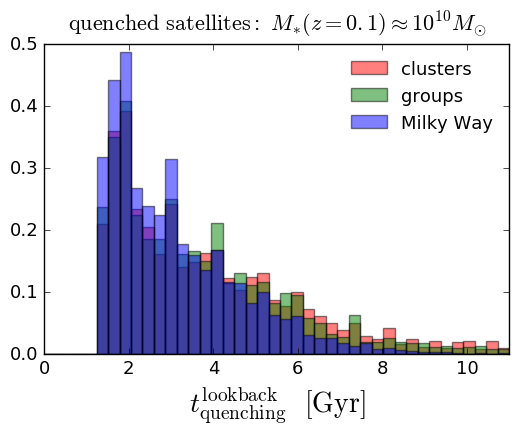

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm_low, sm_high = 10, 10.25

sm_mask = (quenched_sats['stellar_mass'] > 10**sm_low) & (quenched_sats['stellar_mass'] < 10**sm_high)

time_low, time_high = -5, 11
_bins = np.linspace(time_low, time_high, 60)
mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**14) & (quenched_sats['host_mpeak'] < 10**15)
__=plt.hist(cosmic_age_array[-1] - quenched_sats['quenching_time'][mhost_mask], 
            bins=_bins, normed=True, alpha=0.5, 
            label = "clusters", color='red')

mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**13) & (quenched_sats['host_mpeak'] < 10**14)
__=plt.hist(cosmic_age_array[-1] - quenched_sats['quenching_time'][mhost_mask], 
            bins=_bins, normed=True, alpha=0.5, 
            label = "groups", color='green')

mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**12) & (quenched_sats['host_mpeak'] < 10**13)
__=plt.hist(cosmic_age_array[-1] - quenched_sats['quenching_time'][mhost_mask], 
            bins=_bins, normed=True, alpha=0.5, 
            label = "Milky Way", color='blue')

xlabel = ax.set_xlabel(r'$t^{\rm lookback}_{\rm quenching}$  $[{\rm Gyr}]$', fontsize=20)
title = ax.set_title(r'${\rm quenched}$ ${\rm satellites}:$ $M_{\ast}(z=0.1) \approx 10^{10}M_{\odot}$', 
                     fontsize=16, y=1.02) # y param fixes an overhanging title

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(xmin = 0, xmax=time_high)
plt.ylim(ymin = 0, ymax=0.5)
plt.legend(frameon=False, loc='upper right', fontsize=13)
fig.savefig('FIGS/quenching_time_distributions_host_dependence_z0p1.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

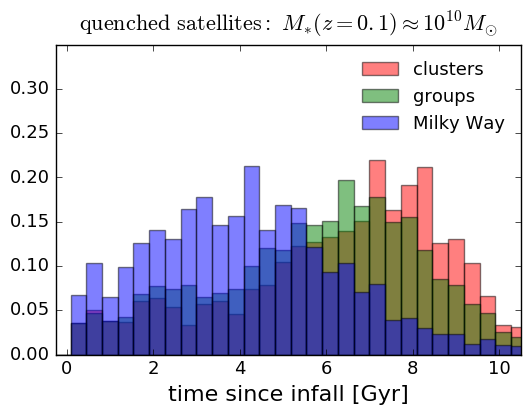

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm_low, sm_high = 10, 10.25

sm_mask = (quenched_sats['stellar_mass'] > 10**sm_low) & (quenched_sats['stellar_mass'] < 10**sm_high)

time_low, time_high = -5, 11
_bins = np.linspace(time_low, time_high, 45)

mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**14) & (quenched_sats['host_mpeak'] < 10**15)
__=plt.hist(t_today - quenched_sats['time_first_acc'][mhost_mask], 
            bins=_bins, normed=True, alpha=0.5, 
            label = "clusters", color='red')

mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**13) & (quenched_sats['host_mpeak'] < 10**14)
__=plt.hist(t_today - quenched_sats['time_first_acc'][mhost_mask], 
            bins=_bins, normed=True, alpha=0.5, 
            label = "groups", color='green')

mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**12) & (quenched_sats['host_mpeak'] < 10**13)
__=plt.hist(t_today - quenched_sats['time_first_acc'][mhost_mask], 
            bins=_bins, normed=True, alpha=0.5, 
            label = "Milky Way", color='blue')

xlabel = ax.set_xlabel(r'$t^{\rm lookback}_{\rm infall}$  $[{\rm Gyr}]$', fontsize=20)
xlabel = ax.set_xlabel(r'time since infall [Gyr]', fontsize=16)
title = ax.set_title(r'${\rm quenched}$ ${\rm satellites}:$ $M_{\ast}(z=0.1) \approx 10^{10}M_{\odot}$', 
                     fontsize=16, y=1.02) # y param fixes an overhanging title

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(xmin = -0.25, xmax=10.5)
plt.ylim(ymin = 0, ymax=0.35)
plt.legend(frameon=False, loc='upper right', fontsize=13)
fig.savefig('FIGS/infall_time_distributions_host_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

### Compare infall time distributions: difference between quenched and star-forming sats

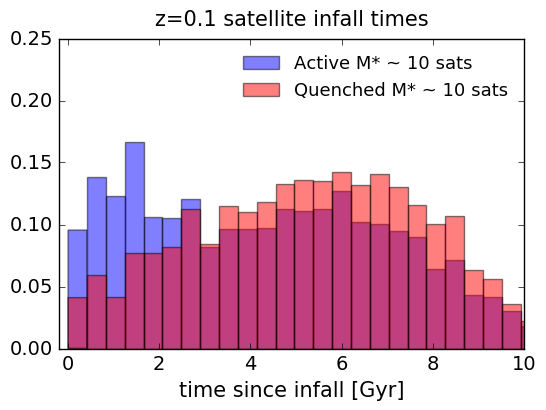

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm_low, sm_high = 10, 10.25

sm_mask = (sats['stellar_mass'] > 10**sm_low) & (sats['stellar_mass'] < 10**sm_high)
quenched_mask = sm_mask * (sats['sfr'] / sats['stellar_mass'] < 1e-11)
active_mask = sm_mask * (sats['sfr'] / sats['stellar_mass'] > 1e-11)

bins=np.linspace(0, 12, 30)
__=plt.hist(t_today - sats['time_first_acc'][active_mask], 
            bins=bins, normed=True, alpha=0.5, 
            label = 'Active M* ~ 10 sats', color='blue')

__=plt.hist(t_today - sats['time_first_acc'][quenched_mask], 
            bins=bins, normed=True, alpha=0.5, 
            label = "Quenched M* ~ 10 sats", color='red')

xlabel = ax.set_xlabel(r'$t_{\rm lookback}^{\rm infall}$  $[{\rm Gyr}]$', fontsize=15)
xlabel = ax.set_xlabel(r'time since infall [Gyr]', fontsize=15)
title = ax.set_title('z=0.1 satellite infall times', fontsize=15, y=1.02) # y param fixes an overhanging title

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin = -0.2, xmax=10)
plt.ylim(ymin = 0, ymax = 0.25)
plt.legend(frameon=False, loc='upper right', fontsize=13)
fig.savefig('FIGS/infall_time_distributions_sfr_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

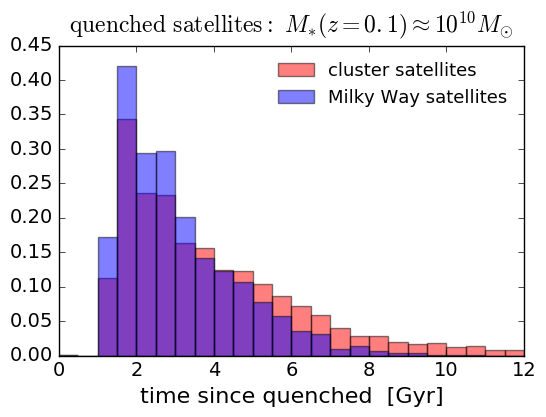

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm_low, sm_high = 10, 10.25

sm_mask = (quenched_sats['stellar_mass'] > 10**sm_low) & (quenched_sats['stellar_mass'] < 10**sm_high)

mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**14) & (quenched_sats['host_mpeak'] < 10**15)

bins=np.linspace(0, 12, 25)

__=plt.hist(cosmic_age_array[-1] - quenched_sats['quenching_time'][mhost_mask], 
            bins=bins, normed=True, alpha=0.5, 
            label = "cluster satellites", color='red')

mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**12) & (quenched_sats['host_mpeak'] < 10**13)
__=plt.hist(cosmic_age_array[-1] - quenched_sats['quenching_time'][mhost_mask], 
            bins=bins, normed=True, alpha=0.5, 
            label = "Milky Way satellites", color='blue')

xlabel = ax.set_xlabel(r'time since quenched  [Gyr]', fontsize=16)
title = ax.set_title(r'${\rm quenched}$ ${\rm satellites}:$ $M_{\ast}(z=0.1)\approx10^{10}M_{\odot}$', fontsize=17, y=1.02) # y param fixes an overhanging title

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin = 0, xmax=12)
plt.ylim(ymin = 0, ymax = 0.45)
plt.legend(frameon=False, loc='upper right', fontsize=13)
fig.savefig('FIGS/quenching_time_distributions_host_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [29]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# sm_low, sm_high = 10, 10.25

# sm_mask = (quenched_sats['stellar_mass'] > 10**sm_low) & (quenched_sats['stellar_mass'] < 10**sm_high)

# mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**14) 
# __=plt.hist(quenched_sats['quenching_time'][mhost_mask] - quenched_sats['time_first_acc'][mhost_mask], 
#             bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
#             label = "Quenched M* ~ 10 sats: [14, 15]", color='red')

# mhost_mask = sm_mask * (quenched_sats['host_mpeak'] > 10**12) & (quenched_sats['host_mpeak'] < 10**13)
# __=plt.hist(quenched_sats['quenching_time'][mhost_mask] - quenched_sats['time_first_acc'][mhost_mask], 
#             bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
#             label = "Quenched M* ~ 10 sats: [12, 13]", color='blue')

# xlabel = ax.set_xlabel(r'$t_{\rm delay}$  $[{\rm Gyr}]$', fontsize=20)
# title = ax.set_title('Quenching time delay distributions', fontsize=17, y=1.02) # y param fixes an overhanging title

# plt.xticks(fontsize=17)
# plt.yticks(fontsize=15)
# plt.xlim(xmin = -0.2, xmax=13)
# plt.ylim(ymin = 0, ymax = 0.45)
# plt.legend(frameon=False, loc='upper right', fontsize=15)
# # fig.savefig('FIGS/delay_time_distributions_host_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')